# COGS 108 - Final Project 

# Overview

I am analyzing data on San Diego's budget expenses regarding to parks and recreation, and to determine its influence on San Diego's poverty levels. I will be using linear regression to determine its influence and to find the correlation between the expenses made vs poverty percentages. After conducting the linear regression analysis, there is no significant correlation between the expenses of San Diego's parks and recreation, and poverty percentages in San Diego. I concluded that there are other factors that influence my analysis, such as geolocation and timeline.

# Name & GitHub

- Name: Kevin Ly
- GitHub Username: KevinUSVN

# Research Question

Does the increase of expenses towards San Diego's parks and recreation services decrease the overall poverty percentages of San Diego in the past decade (2010-2020)?

## Background and Prior Work

Parks in America play major role in the community's well-being as it provides societal benefits such as improved infrastruture, attractive investments, improved environmental health, and green space [1]. Although parks provide many benefits to our community, there are unequal amount of access to parks in the United States. The size and its location vary by size and distance, and those who live far from these parks will not receive any benefits [1]. There are some discussions whether park access and availability contributes to the decrease in poverty within the area. According to the Brookings analysis on park access and poverty rates by metro area, they conclude that there is a decrease in poverty rates when higher shares of population have access to nearby parks [1]. I am curious to see whether an increase in expenses towards parks could decrease the amount of poverty in the San Diego county as I figure that more expenses towards parks would indirectly increase park accessibility.

According to the Inquirer, "poverty is directly linked to health outcomes" [2]. These health outcomes are tied to location, level of education, and race [2]. This article focuses more on the location aspect of health, where the location you live will determine your life expectancy, as stated "being born in zip codes just five miles apart can result in a 20-year difference in life expectancy" [2]. Factors that locations have in a person's well being is the access to closer emergency services, pollution from highways, access to gyms, unhealthy housing, access to quality education, etc.. Parks is one of these factors that can influence a person's well being. The article suggest we heal our city by providing more access to parks, which contributes to more green space. The article states that researches conducted since the 1980's have been consistently showing the benefits of having green space such as parks. My research question helps to contribute the discussion and support for green space by determining whether spending more on parks and recreation decreases the amount of poverty in the area.

References (include links):
- 1) https://www.brookings.edu/blog/the-avenue/2019/08/21/parks-make-great-places-but-not-enough-americans-can-reach-them/
- 2) https://www.inquirer.com/health/parks-poverty-philadelphia-20190408.html

# Hypothesis


Additional expenses towards parks and recreation services would slightly decrease the amount of poverty in San Diego by an estimated 5% after a decade. 

It is important to have parks as it promotes individual health and community well-being as it incorporates nature to our everyday lives. By spending more on parks and recreation, it fosters a stronger community bond, and further attracts business investments that can potentially reduce poverty in the local area.

# Dataset(s)

- Dataset Name: San Diego Budget Data
- Link to the dataset: https://data.sandiego.gov/datasets/operating-actuals/
- Number of observations: 454891
- Columns: "amount","report_fy","fund_type","fund_number","dept_name","funds_center_number","account","account_number". 

The usage of this dataset is to retrieve expenses for parks and recreation by reporting years. For this analysis I am only interested in columns: "amount","report_fy","dept_name","account_number". Amount is how much spending/expense used in a department, these values take on either positive or negative float types. The report_fy column contains an integer value that represents the last two digits of the millenium 2000 (e.g. '17' corresponds to '2017'). The dept_name column represents the department name of San Diego as a string object. The account_number represents the account number that the expenses used as an integer value. Account numbers that are revenues begins with '4' and expenses begins with '5'.


- Dataset Name: California Environmental Health Screening Data
- Link to the dataset: https://data.ca.gov/dataset/calenviroscreen-2-0
- Number of observations: 8035
- Columns: Census Tract,Total Population,California County,Click for interactive map,CES 2.0 Score,CES 2.0 Percentile Range,Hyperlink,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Age,Age Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Pop. Char. ,Pop. Char. Score,Pop. Char. Pctl,Location 1

The usage of this dataset is to retrieve information on poverty levels within San Diego. The columns I am interested in is California County and Poverty. The column California County represents the California county that the census tract falls within, and the values are in string objects. The column Poverty represents the percent of population living below two times the federal poverty level as float values.

I planned to merge these data sets in order to use multivariate linear regression. I will first need to clean and pick out desirable rows and columns, then attempt to merge them together. However since the California Environmental Health Screening Data does not have some sort of timeline, I will assume it is orderded from oldest to newest by row. So I have to reorder the budget data set by year before I start merging them together. This is where the limitations of my chosen dataset, and the results of the analysis will be based on heavy assumptions on the timeline. Additionally, the San Diego Budget Data has almost 50 times more observations than the California Environmental Health Screening dataset, so I have to trim down the data to fit 8035 observations. I have to be extra careful to spread the dataset out where each CA enviro dataset row corresponds to every (actuals_operating_datasd.size() // calenviroscreen-final-report.size())th rows of the San Diego Budget dataset.

# Setup

In [1]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

In [2]:
# Retrieve California Environmental Health Screening Data and San Diego Budget Data
df_budget = pd.read_csv('../data/actuals_operating_datasd.csv')
df_poverty = pd.read_csv('../data/calenviroscreen-final-report.csv')

# Data Cleaning

Currently the datasets chosen are fairly clean. There are only a few NaN values (about 10 observations) in the California Environmental Health Screening dataset. There are some procedures I like to standardize and renamed in these datasets, but overall the datasets are fairly clean.

## Dataset cleaning: San Diego Budget Data
Below is the procedure for cleaning San Diego Budget Data.

I choose my desired columns: amount, report_fy, dept_name, and account_number. I filter the data set to only have account numbers start with '5' since the accounts that start with 5 are expenses. Next step is to choose rows that contains 'Parks & Recreation'. Then I sort the dataset by year from oldest to newest. Finally remove any NaN values from the dataset if they exist.

In [3]:
# Choose columns: amount, report_fy, and dept_name
df_budget = df_budget[['amount', 'report_fy', 'dept_name', 'account_number']]

# Change account_number into string type
df_budget['account_number'] = df_budget['account_number'].astype(str)

# Choose rows that account_number starts with '5'
df_budget = df_budget[df_budget['account_number'].str.startswith('5')]

# Change back to int64 type
df_budget['account_number'] = df_budget['account_number'].astype('int64')

# Choose rows that dept_name has 'Parks & Recreation'
df_budget = df_budget[df_budget['dept_name'] == 'Parks & Recreation']

# Sort dataset by year
df_budget = df_budget.sort_values(by='report_fy')

# Remove any NaN values (drop NaN for amount and report_fy)
df_budget = df_budget.dropna(subset=['amount', 'report_fy'])

# Reset index
df_budget = df_budget.reset_index()

print('San Diego Budget observations:', df_budget.shape[0])
df_budget.head(5)

San Diego Budget observations: 81210


,index,amount,report_fy,dept_name,account_number
0,305000,10.49,11,Parks & Recreation,502013
1,306578,2292.69,11,Parks & Recreation,502051
2,306577,336.79,11,Parks & Recreation,502050
3,306576,1533.17,11,Parks & Recreation,502049
4,306575,2626.99,11,Parks & Recreation,502048


## Dataset cleaning: California Environmental Health Screening Data
Below is the procedure for cleaning California Environmental Health Screening Data.

In this dataset, I choose my desired columns: California County and Poverty. I select rows that contain 'San Diego' under California County. Then remove any NaN values in the dataset.

In [4]:
# Choose columns: California County and Poverty
df_poverty = df_poverty[['California County', 'Poverty']]

# Select rows that contain San Diego under California County
df_poverty = df_poverty[df_poverty['California County'] == 'San Diego']

# Remove NaN values
df_poverty = df_poverty.dropna()

# Reset index
df_poverty = df_poverty.reset_index()

# Set row_id as new column
df_poverty['row_id'] = df_poverty.index

print('California Environmental Health Screening current observations:', df_poverty.shape[0])
df_poverty.head(5)

California Environmental Health Screening current observations: 617


,index,California County,Poverty,row_id
0,165,San Diego,74.855946,0
1,299,San Diego,76.636392,1
2,370,San Diego,70.019802,2
3,466,San Diego,76.470588,3
4,805,San Diego,79.242069,4


## Merging San Diego Budget and California Environmental Health Datasets

Below is the procedure to merge two datasets into one in order to use linear regression analysis much easier.

This is where one of the datasets limitations occurs. In the California Environmental Health dataset, there is not enough observations (617 observations) to "intersect" or match up with San Diego Budget dataset (81210 observations) (after data has been cleaned). Additionally, the California Environmental Health dataset does not provide any sort of timeline regarding which year the observation was reported on in the 2010 decade. So I have to assume that the rows in the dataset to be sorted by year (oldest to newest). With that assumption, I must merge with every nth row in the San Diego Budget dataset in order to get an even distribution of expenses with the California Environmental Health dataset. I must spread out the rows because I need a good enough estimation to place each of the budget observations that might appear in the decade timeline of the California Environmental Health dataset.

When calculating the spread of the budget dataset, I noticed there are a few extreme values which may skew the linear regression analysis. These extreme values occur 200,000 or above in the amount column. Fortunately, after removing these extreme values, my observations went from 620 to 612. However it will expected that some of California Environmental Health dataset will be trimmed off from 617 rows to 612 rows after the merge.

In [5]:
# Obtain even distribution of rows in the San Diego Budget dataset
row_iter = df_budget.shape[0] // df_poverty.shape[0]
df_budget_spread = df_budget.iloc[::row_iter, :]

# Remove extreme values in 'amount' that is above 200,000
df_budget_spread_trim = df_budget_spread[df_budget_spread['amount'] < 200000]

# Reset index
df_budget_spread_trim = df_budget_spread_trim.reset_index()

# Set row_id as new column
df_budget_spread_trim['row_id'] = df_budget_spread_trim.index

# Merge df_poverty and df_budget_spread_trim
df = df_budget_spread_trim.merge(df_poverty, on='row_id')

# Drop any missing values
df = df.dropna()

## Renaming Columns and Values
The purpose of this section is rename columns, particularly for 'amount' and 'report_fy', as well as standardize values in report_fy. For the 'amount' column, it will be renamed to 'expenses'. For the 'report_fy' column, it will be renamed to year. The values in 'report_fy' will have '20' appended in front of the existing values to achieve the full year format ('11' -> '2011'). All of these changes in this section will be applied to the merged dataset 'df'. This is to make columns and values more readable.

In [6]:
# Rename columns
df = df.rename(columns={'amount': 'expenses', 'report_fy': 'year'})

# Change values in year
df['year'] = '20' + df['year'].astype(str)
df['year'] = df['year'].astype('int64')

df.head()

,level_0,index_x,expenses,year,dept_name,account_number,row_id,index_y,California County,Poverty
0,0,305000,10.49,2011,Parks & Recreation,502013,0,165,San Diego,74.855946
1,131,306621,27.72,2011,Parks & Recreation,502056,1,299,San Diego,76.636392
2,262,306471,497.50,2011,Parks & Recreation,511062,2,370,San Diego,70.019802
3,393,306892,289.10,2011,Parks & Recreation,502013,3,466,San Diego,76.470588
4,524,306750,48.49,2011,Parks & Recreation,511094,4,805,San Diego,79.242069


# Data Analysis & Results

## Exploratory Data Visualizations and Analysis
Below is a brief preview of the dataset: df, where both San Diego Budget and California Environmental Health datasets were merged together. The ordering by timeline assumptions, and the removal of extreme values in 'amount' column (amount > 200,000) have been already dealt with in the data cleaning procedure above. 

In [7]:
df

,level_0,index_x,expenses,year,dept_name,account_number,row_id,index_y,California County,Poverty
0,0,305000,10.49,2011,Parks & Recreation,502013,0,165,San Diego,74.855946
1,131,306621,27.72,2011,Parks & Recreation,502056,1,299,San Diego,76.636392
2,262,306471,497.50,2011,Parks & Recreation,511062,2,370,San Diego,70.019802
3,393,306892,289.10,2011,Parks & Recreation,502013,3,466,San Diego,76.470588
4,524,306750,48.49,2011,Parks & Recreation,511094,4,805,San Diego,79.242069
...,...,...,...,...,...,...,...,...,...,...
607,80565,412016,77.03,2019,Parks & Recreation,502077,607,7879,San Diego,3.319400
608,80696,412808,1369.79,2019,Parks & Recreation,500134,608,7881,San Diego,12.469928
609,80827,412997,393.46,2019,Parks & Recreation,502050,609,7884,San Diego,32.896505
610,80958,412426,102.28,2019,Parks & Recreation,500022,610,7895,San Diego,11.845450


### Visualizing Budget Expenses Over Time
Below is a boxplot that shows the range of expenses for each year. I calculated the mean (for each year), overall mean, max, min, and range values of these amounts below. From my calculations, the overall mean expense is $5637, and notice there are some extreme values above the $5637 mean according to the visualization.

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Expenses (in US dollars $)')]

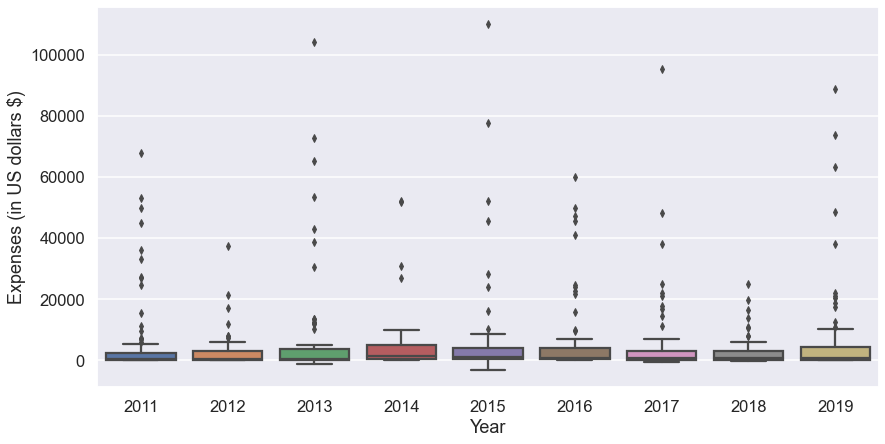

In [8]:
# Plot year in x-axis and expenses in y-axis as a boxplot to see the spread of expenses within each year
fig_dims = (14, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.boxplot(data=df, x='year', y='expenses', ax=ax)
ax.set(xlabel='Year', ylabel='Expenses (in US dollars $)')

In [9]:
# Calculate the mean of expenses each year
list_means = df.groupby('year')['expenses'].mean()
overall_mean = df['expenses'].mean()

print('Means of expenses for each year')
print(list_means, '\n')

# Calculate the overall mean, max, min, and range
print('Overall mean:', overall_mean)
print('Max:', df['expenses'].max())
print('Min:', df['expenses'].min())
print('Range:', df['expenses'].max() - df['expenses'].min())

Means of expenses for each year
year
2011    5701.984167
2012    2698.712429
2013    7752.089104
2014    4710.649062
2015    7211.347258
2016    6729.033077
2017    5654.528308
2018    2755.417910
2019    7712.399706
Name: expenses, dtype: float64 

Overall mean: 5636.992238562098
Max: 110002.18
Min: -3201.44
Range: 113203.62


Below here is the scatter plot to show how much amount (expenses) changes over time. At first glance, it seems that there are fluctuations on the amount of expenses, which may influence my future analysis. Also there seems to have no increase or decrease in expenses over time.

[Text(0.5, 0, 'row_id'), Text(0, 0.5, 'Expenses (in US dollars $)')]

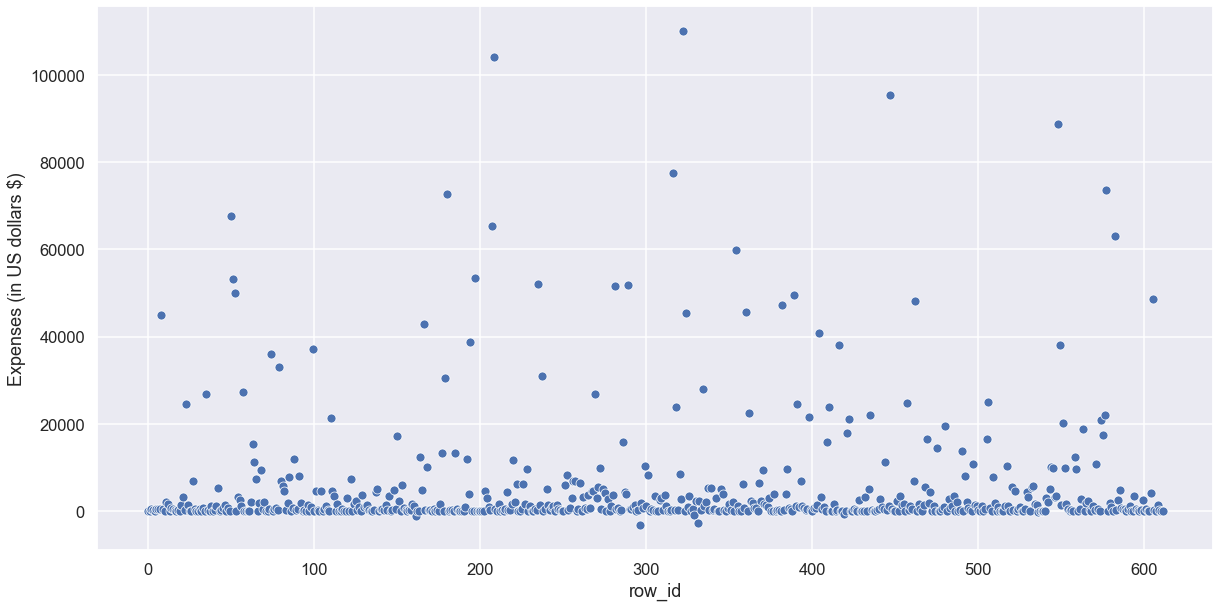

In [10]:
# Plot scatter plot
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(data=df, x='row_id', y='expenses', ax=ax)
ax.set(xlabel='row_id', ylabel='Expenses (in US dollars $)')

### Visualizing Poverty Percentages Over Time
Below is a boxplot to show the range of poverty percentages it can take for each year. The year 2019 shows the least amount of poverty percentages.

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Poverty (%)')]

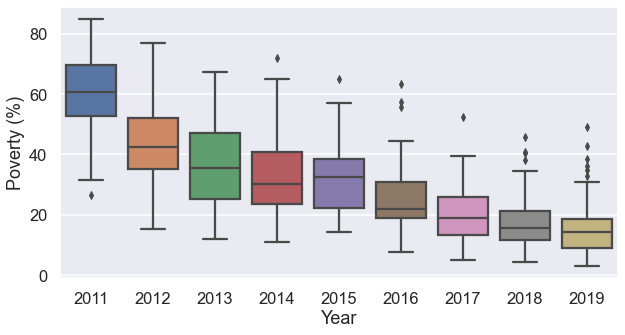

In [11]:
# Plot year in x-axis and poverty percentages in y-axis as a boxplot to see the spread of poverty within each year
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.boxplot(data=df, x='year', y='Poverty', ax=ax)
ax.set(xlabel='Year', ylabel='Poverty (%)')

Below here is a scatter plot that shows poverty percentages over time. The scatter plot appears that poverty is decreasing over time based on assumptions on the timeline from the California Environmental Health dataset. There is a possibility that the dataset is sorted by geolocation, and/or are biased through geolocation, however it is out of scope for my analysis. For now I am basing on the assumption that the dataset is ordered from oldest to newest to provide the simplest means of answering my hypothesis.

The scatter plot is somewhat tight and shows no obvious extreme values.

[Text(0.5, 0, 'row_id'), Text(0, 0.5, 'Poverty (%)')]

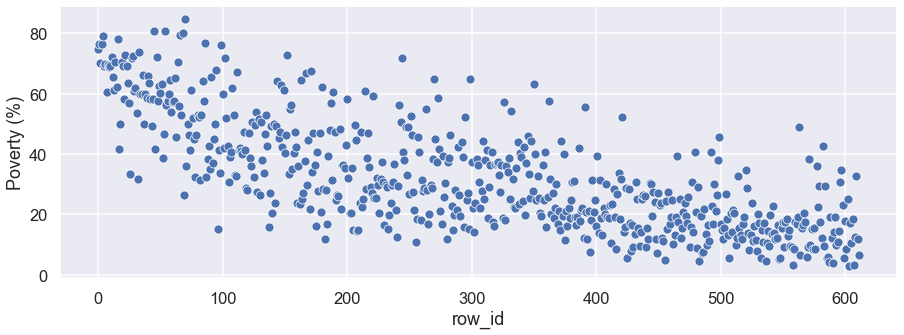

In [12]:
# Plot scatter plot
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(data=df, x='row_id', y='Poverty', ax=ax)
ax.set(xlabel='row_id', ylabel='Poverty (%)')

## Linear Regression Analysis
I will be using linear model using OLS (Ordered Least Squares) to predict poverty percentages with expenses. This method will be used to determine if there is an influence towards poverty percentages using expenses. I will rely on measuring the p-value from OLS regression results using alpha 0.01 to determine if there is an influence.

In [13]:
outcome, predictors = patsy.dmatrices('Poverty ~ expenses', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

# Print out the summary results of the model fitting
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                 0.0008819
Date:                Wed, 16 Dec 2020   Prob (F-statistic):              0.976
Time:                        20:12:21   Log-Likelihood:                -2651.2
No. Observations:                 612   AIC:                             5306.
Df Residuals:                     610   BIC:                             5315.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     32.4955      0.805     40.387      0.0

In [14]:
# Assess p-value
isSig = bool(res.pvalues[1] < 0.01)
print('Does expenses in San Diego parks and recreation have an influence over San Diego\'s poverty percentages?', isSig)

Does expenses in San Diego parks and recreation have an influence over San Diego's poverty percentages? False


According to the linear regression analysis, expenses has a p-value of 0.976 which is greater than the alpha 0.01. Therefore, expenses towards San Diego's parks and recreations does not significantly affect poverty percentage in San Diego's poverty. This means the evidence does not support my research hypothesis.

Additionally, the OLS regression results shows a warning that it indicates a strong multicollinearity among the variables, which may greatly affect findings. One way to reduce multicollinearity in the dataset is find indepedent variables that are not correlated. The best approach to solving this issue is to find more specific datasets that work closely to the hypothesis. My assumption in timeline of the California Environmental Health dataset can also factor in the issue

# Ethics & Privacy

My research question does not provide any personal identifiable information as it is dependent on the data from public government websites.

Data from San Diego's government website (https://data.sandiego.gov/datasets/operating-actuals/) is under Open Data Commons Public Domain Dedication and Licence (PDDL), which is free and publicly available for use. Additionally, the data from California's government website (https://data.ca.gov/dataset/calenviroscreen-2-0) states there are no restrictions for the use of its datasets, as well as it is publicly available for use. The datasets chosen allows me to freely adapt, transform, and publicly share my analysis if desired.

In regards to data privacy, there are no observations that reveal any personal identifiable private information as all of the data in the chosen datasets are submmitted publicly by their respective governments.

There is a possibily for human biases when manipulating the datasets. In my case, I made the assumption that the California Environmental Health dataset is ordered by year within the 2010 decade. This assumption significantly impacted my findings in answering my hypothesis. To avoid this assumption, I have to find a specific dataset that records the date of the observations as well as records poverty percentages. Additionally, from my exploratory visual analysis regarding the California Environmental Health dataset, I notice poverty percentages are decreasing when going through row by row. This may suggest a bias in geolocation favorability, however I need to conduct geoanalysis in order to prove that this is the case.

Overall, despite the issues of biases within my analysis, the analysis is fairly ethical, and retains privacy.

# Conclusion & Discussion

After conducting my analysis on my research hypothesis using linear regression, "Additional expenses towards parks and recreation services would slightly decrease the amount of poverty in San Diego by an estimated 5% after a decade", I concluded that the evidence does not support this hypothesis as it found no influence on poverty percentages using expenses.

There are limitations to my datasets that may easily sway my results using linear regression. First, is that I assumed that the California Environmental Health dataset is sorted by year within the decade of 2010. This analysis relies heavily on time, and it needs to be mapped correctly with the reported poverty percentages and expenses in the 2010 decade. One solution I can come up with is to find a specific dataset that records the date of the observations as well as recording information that relates to expenses and poverty percentages. Second, there are some geographical biases within the California Environmental Health dataset. Upon visualizing the poverty percentages, I notice there is a decrease in poverty percentages and wonder if geolocation bias determines this decrease. I need to make additional geolocation analysis to determine if this bias is correct.

In conclusion, my linear regression analysis does not support my hypothesis. I need to find more thorough datasets and conduct more analysis to reduce amount of biases in order to answer my hypothesis conclusively.